In [1]:
import os
import sys
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import class_weight
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, Activation, Input, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import TensorBoard, ModelCheckpoint, LearningRateScheduler
from keras import regularizers

Using TensorFlow backend.


In [2]:
drive_base_path = "../"
path_to_images = drive_base_path + "dataset/ISIC2018_Training_Input/"
path_to_balanced_images = drive_base_path + "dataset/Balanced_Training_Input_Aug/"

In [3]:
NAME = "ResNet50_%s" % (int(time.time()))
tensorboard = TensorBoard(log_dir='./logs/%s' % (NAME))

In [4]:
filepath = drive_base_path + "models/checkpoint/ResNet50.{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [5]:
def load_sample(path_to_images, number_of_images):
    list_of_images = os.listdir(path_to_images)
    x = []
    for i, filename in enumerate(list_of_images):
        image = cv2.imread(path_to_images + filename)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        x.append(image)
        
        if i >= number_of_images:
            break
    
    x = np.array(x)
    return x      

In [6]:
x = load_sample(path_to_images, 1000)
print(x.shape)

(1001, 450, 600, 3)


In [7]:
datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.2,
    fill_mode='constant',
    cval=0,
    validation_split=0.1,
    data_format="channels_last")

In [8]:
datagen.fit(x)

In [9]:
classes = ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']
batch_size = 32
train_generator = datagen.flow_from_directory(
                    directory=path_to_balanced_images,
                    target_size=(224, 224),
                    batch_size=batch_size,
                    classes=classes,
                    shuffle=True,
                    subset='training')

validation_generator = datagen.flow_from_directory(
                    directory=path_to_balanced_images,
                    target_size=(224, 224),
                    batch_size=batch_size,
                    classes=classes,
                    shuffle=True,
                    subset='validation')

Found 29871 images belonging to 7 classes.
Found 3317 images belonging to 7 classes.


In [10]:
train_samples = train_generator.samples
valid_samples = validation_generator.samples

In [9]:
_x, _y = next(train_generator)

In [11]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

print(class_weights)

[1.06495775 0.7070896  1.08196899 1.11533866 1.07841438 1.03074534
 1.07705344]


# DEFINING THE MODEL

In [12]:
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dense(1000,
#           kernel_regularizer=regularizers.l2(1e-4),
#           activation='relu')(x)
# x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss="categorical_crossentropy", 
              optimizer=Adam(lr=1e-3), 
              metrics=["acc"])
print(model.summary())

/data/anaconda/envs/py36_fixed/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [18]:
epochs = 5
history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_samples / batch_size,
                              validation_data=validation_generator,
                              validation_steps=valid_samples / batch_size,
                              epochs=epochs,
#                               class_weight=class_weights,
                              verbose=1,
                              callbacks=[tensorboard, checkpoint])

Epoch 1/5
934/933 [==============================] - 501s 536ms/step - loss: 0.9649 - acc: 0.6442 - val_loss: 0.9326 - val_acc: 0.6617

Epoch 00001: val_acc improved from -inf to 0.66174, saving model to ../models/checkpoint/ResNet50.01-0.66.hdf5
Epoch 2/5
934/933 [==============================] - 494s 528ms/step - loss: 0.7236 - acc: 0.7325 - val_loss: 0.8875 - val_acc: 0.6813

Epoch 00002: val_acc improved from 0.66174 to 0.68134, saving model to ../models/checkpoint/ResNet50.02-0.68.hdf5
Epoch 3/5
934/933 [==============================] - 494s 529ms/step - loss: 0.6501 - acc: 0.7590 - val_loss: 0.8530 - val_acc: 0.6853

Epoch 00003: val_acc improved from 0.68134 to 0.68526, saving model to ../models/checkpoint/ResNet50.03-0.69.hdf5
Epoch 4/5
934/933 [==============================] - 493s 528ms/step - loss: 0.6097 - acc: 0.7722 - val_loss: 0.8152 - val_acc: 0.6961

Epoch 00004: val_acc improved from 0.68526 to 0.69611, saving model to ../models/checkpoint/ResNet50.04-0.70.hdf5
Epo

### Load model from checkpoint

In [19]:
filepath = drive_base_path + "models/checkpoint/ResNet50.05-1.00.hdf5"
model = load_model(filepath)

In [20]:
epochs = 5
history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_samples / batch_size,
                              validation_data=validation_generator,
                              validation_steps=valid_samples / batch_size,
                              epochs=epochs,
#                               class_weight=class_weights,
                              verbose=1,
                              callbacks=[tensorboard, checkpoint])

Epoch 1/5
1867/1866 [==============================] - 498s 267ms/step - loss: 0.6375 - acc: 0.7638 - val_loss: 1.0430 - val_acc: 0.6427

Epoch 00002: val_acc did not improve from 0.64667
Epoch 3/5
1447/1866 [======================>.......] - ETA: 1:40 - loss: 0.6274 - acc: 0.7618

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1867/1866 [==============================] - 498s 267ms/step - loss: 0.6023 - acc: 0.7756 - val_loss: 1.1428 - val_acc: 0.6120

Epoch 00005: val_acc did not improve from 0.64667


In [19]:
filepath = drive_base_path + "models/checkpoint/ResNet50.04-0.70.hdf5"
model = load_model(filepath)

In [13]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name, layer.trainable)

# for layer in model.layers[:161]:
#     layer.trainable = False
for layer in model.layers:
    layer.trainable = True

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 conv1_pad True
2 conv1 True
3 bn_conv1 True
4 activation_1 True
5 pool1_pad True
6 max_pooling2d_1 True
7 res2a_branch2a True
8 bn2a_branch2a True
9 activation_2 True
10 res2a_branch2b True
11 bn2a_branch2b True
12 activation_3 True
13 res2a_branch2c True
14 res2a_branch1 True
15 bn2a_branch2c True
16 bn2a_branch1 True
17 add_1 True
18 activation_4 True
19 res2b_branch2a True
20 bn2b_branch2a True
21 activation_5 True
22 res2b_branch2b True
23 bn2b_branch2b True
24 activation_6 True
25 res2b_branch2c True
26 bn2b_branch2c True
27 add_2 True
28 activation_7 True
29 res2c_branch2a True
30 bn2c_branch2a True
31 activation_8 True
32 res2c_branch2b True
33 bn2c_branch2b True
34 activation_9 True
35 res2c_branch2c True
36 bn2c_branch2c True
37 add_3 True
38 activation_10 True
39 res3a_branch2a True
40 bn3a_branch2a True
41 activation_11 True
42 res3a_branch2b True
43 bn3a_branch2b True
44 activation_12 True
45 res3a_branch2c True
46 res3a_branch1 True
47 bn3a_branch2c True
4

In [14]:
NAME = "ResNet50_REST_%s" % (int(time.time()))
tensorboard = TensorBoard(log_dir='./logs/%s' % (NAME))

In [15]:
filepath = drive_base_path + "models/checkpoint/ResNet50_REST.{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [23]:
model.compile(optimizer=SGD(lr=1e-3, momentum=0.9), loss='categorical_crossentropy', metrics=["acc"])
epochs = 10
history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_samples / batch_size,
                              validation_data=validation_generator,
                              validation_steps=valid_samples / batch_size,
#                               class_weight=class_weights,
                              epochs=epochs,
                              verbose=1,
                              callbacks=[tensorboard, checkpoint])
# model.save_weights(drive_base_path + 'models/ResNet50_ISIC.h5')
# model.evaluate(X_test, y_test)

Epoch 1/10
934/933 [==============================] - 817s 875ms/step - loss: 0.5258 - acc: 0.8136 - val_loss: 0.7833 - val_acc: 0.7462

Epoch 00001: val_acc improved from -inf to 0.74616, saving model to ../models/checkpoint/ResNet50_REST.01-0.78.hdf5
Epoch 2/10
934/933 [==============================] - 810s 867ms/step - loss: 0.2348 - acc: 0.9112 - val_loss: 0.8375 - val_acc: 0.7742

Epoch 00002: val_acc improved from 0.74616 to 0.77419, saving model to ../models/checkpoint/ResNet50_REST.02-0.84.hdf5
Epoch 3/10
934/933 [==============================] - 810s 867ms/step - loss: 0.1519 - acc: 0.9429 - val_loss: 1.0813 - val_acc: 0.7465

Epoch 00003: val_acc did not improve from 0.77419
Epoch 4/10
934/933 [==============================] - 810s 867ms/step - loss: 0.1071 - acc: 0.9612 - val_loss: 0.8400 - val_acc: 0.8095

Epoch 00004: val_acc improved from 0.77419 to 0.80947, saving model to ../models/checkpoint/ResNet50_REST.04-0.84.hdf5
Epoch 5/10
934/933 [============================

### Load from checkpoint

In [20]:
filepath = drive_base_path + "models/checkpoint/ResNet50_REST.04-0.87.hdf5"
model = load_model(filepath)

In [21]:
NAME = "ResNet50_REST_%s" % (int(time.time()))
tensorboard = TensorBoard(log_dir='./logs/%s' % (NAME))

In [ ]:
model.compile(optimizer=SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=["acc"])
epochs = 4
history = model.fit_generator(train_generator, 
                              steps_per_epoch=train_samples / batch_size,
                              validation_data=validation_generator,
                              validation_steps=valid_samples / batch_size,
#                               class_weight=class_weights,
                              epochs=epochs,
                              verbose=1,
                              callbacks=[tensorboard, checkpoint])

Epoch 1/4
934/933 [==============================] - 836s 895ms/step - loss: 0.0069 - acc: 0.9985 - val_loss: 0.8864 - val_acc: 0.8267

Epoch 00001: val_acc did not improve from 0.83057
Epoch 2/4
934/933 [==============================] - 831s 890ms/step - loss: 0.0062 - acc: 0.9987 - val_loss: 0.9545 - val_acc: 0.8173

Epoch 00002: val_acc did not improve from 0.83057
Epoch 3/4
934/933 [==============================] - 831s 890ms/step - loss: 0.0063 - acc: 0.9986 - val_loss: 0.9395 - val_acc: 0.8221

Epoch 00003: val_acc did not improve from 0.83057
Epoch 4/4
656/933 [====================>.........] - ETA: 3:53 - loss: 0.0059 - acc: 0.9986

# ACCURACY AND LOSS PLOTS

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


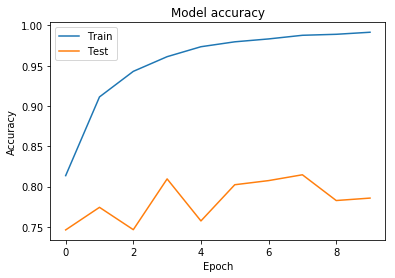

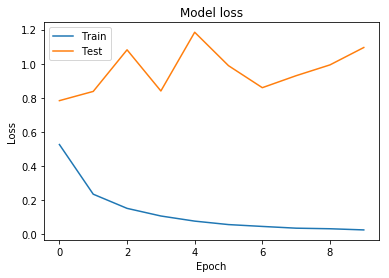

In [24]:
# Plot Training and Validation Accuracy
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# CONFUSION MATRIX

In [25]:
classes = ['mel', 'nv', 'bcc', 'akiec', 'bkl', 'df', 'vasc']
validation_generator = datagen.flow_from_directory(
                    directory=path_to_balanced_images,
                    target_size=(224, 224),
                    batch_size=1,
                    classes=classes,
                    shuffle=False,
                    subset='validation')

Found 3317 images belonging to 7 classes.


In [26]:
filepath = drive_base_path + "models/checkpoint/ResNet50_REST.08-0.93.hdf5"
model.load_weights(filepath)

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

Y_pred = model.predict_generator(validation_generator, steps=valid_samples / 1)
y_pred = np.argmax(Y_pred, axis=1)

In [35]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix


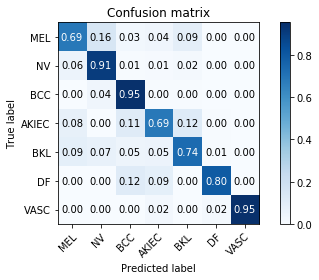

In [36]:
class_names = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]
plot_confusion_matrix(validation_generator.classes, y_pred, classes=class_names, title='Confusion matrix', normalize=True)
plt.show()

# ISIC LIVE IMAGE TEST/VALIDATION DATA

In [37]:
# TESTTING ON ISIC LIVE IMAGE DATA
path_to_images = drive_base_path + "dataset/ISIC2018_Task3_Test_Input/"

In [38]:
def preprocess_images(path_to_images):
    images_list = []
    filename_list = []
    
    path_to_images = path_to_images + 'test/'
    
    input_size = 224
    list_of_images = os.listdir(path_to_images)
    number = len(list_of_images)
    
    for filename in tqdm(list_of_images, total=number):
        filename_list.append(filename[:-4])
        
        image = cv2.imread(path_to_images + filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        old_size = image.shape[:2] # height, width

        ratio = float(input_size)/max(old_size)
        new_size = tuple([int(x*ratio) for x in old_size])

        image = cv2.resize(image, (new_size[1], new_size[0]))
        delta_w = input_size - new_size[1]
        delta_h = input_size - new_size[0]
        top, bottom = delta_h//2, delta_h-(delta_h//2)
        left, right = delta_w//2, delta_w-(delta_w//2)

        color = [0, 0, 0]
        new_img = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, 
                                    value=color)

        images_list.append(new_img)
        
    images_list = np.array(images_list)
    filename_list = np.array(filename_list)
    filename_list = filename_list[:, None]
    return (images_list, filename_list)

In [39]:
x_test, names = preprocess_images(path_to_images)

(1512, 224, 224, 3)
(1512, 1)


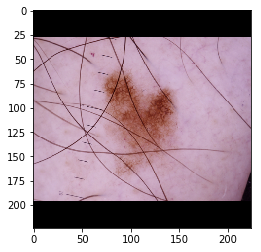

In [40]:
print(x_test.shape)
print(names.shape)
plt.imshow(x_test[5])

In [42]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    data_format="channels_last")

In [43]:
test_datagen.fit(x_test)

In [44]:
test_generator = test_datagen.flow(
                    x_test,
                    batch_size=1,
                    shuffle=False)

In [45]:
filepath = drive_base_path + "models/checkpoint/ResNet50_REST.08-0.93.hdf5"
model.load_weights(filepath)

In [46]:
predictions = model.predict_generator(test_generator, steps=len(x_test))
# classes = (predictions > 0.5).astype(np.float)
# print(classes.shape)

In [47]:
print(predictions.shape)

(1512, 7)


In [48]:
final_output = np.concatenate((names, predictions), axis=1)
final_output.shape

(1512, 8)

In [49]:
import csv

with open(drive_base_path + "output.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["image", "MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"])
    writer.writerows(final_output)